<a href="https://colab.research.google.com/github/Su-ok/MT2025124_ML_Project/blob/main/KagObesityXGB18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier
import xgboost as xgb
np.random.seed(42)

train= pd.read_csv("/content/drive/MyDrive/ML kaggle data/train.csv")
test= pd.read_csv("/content/drive/MyDrive/ML kaggle data/test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Basic preprocessing
X= train.drop(["WeightCategory", "id"], axis=1)
y= train["WeightCategory"]

# Encode categorical features
for col in X.select_dtypes(include=['object']).columns:
    le= LabelEncoder()
    X[col]= le.fit_transform(X[col])
    if col in test.columns:
        test[col]= le.transform(test[col])

# Encode target labels
y_le= LabelEncoder()
y= y_le.fit_transform(y)

scaler= StandardScaler()
X_scaled= scaler.fit_transform(X)
test_scaled= scaler.transform(test.drop("id", axis=1))

# Step 4: Split train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


xgbmodel=XGBClassifier(objective="multi:softmax",
                    random_state=42,
                    num_class=len(np.unique(y)),
                    use_label_encoder=False,
                    eval_metric="mlogloss",
                    n_estimators=5000)

param_dist= {'max_depth': [4],
             'learning_rate': [0.005, 0.01, 0.03],
             'subsample': [0.7, 0.8, 0.9],
             'colsample_bytree': [0.7, 0.8, 0.9],
             'gamma': [0.8, 0.9],
             'min_child_weight':[5,7],
             'reg_alpha':[0.01, 0.1, 1],
             'reg_lambda': [5.0, 6.0]}

cv_strat=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rndm_search=RandomizedSearchCV(estimator=xgbmodel,
                               param_distributions=param_dist,
                               n_iter=20,
                               scoring='accuracy',
                               n_jobs=-1,
                               cv=cv_strat,
                               random_state=42,
                               verbose=2,
                               )

rndm_search.fit(X_train, y_train)
print("Best Parameters Found:")
print(rndm_search.best_params_)
print(f"best CV Accuracy: {rndm_search.best_score_:.6f}")

best_xgb=rndm_search.best_estimator_
y_train_pred=best_xgb.predict(X_train)
y_val_pred=best_xgb.predict(X_val)

train_acc=accuracy_score(y_train, y_train_pred)
val_acc=accuracy_score(y_val, y_val_pred)
print(f"\nTraining Accuracy with tuned XGBoost: {train_acc:.6f}")
print(f"\nValidation Accuracy with tuned XGBoost: {val_acc:.6f}")

# Retrain with Native XGBoost and Early Stopping
'''final_xgb=XGBClassifier(**rndm_search.best_params_,
                        objective="multi:softmax",
                        num_class=len(np.unique(y)),
                        random_state=42,
                        use_label_encoder=False,
                        eval_metric="mlogloss") '''
best_params=rndm_search.best_params_
native_params={"objective": "multi:softprob",
               "num_class":len(np.unique(y)),
               "eta": best_params['learning_rate'],
               "max_depth": best_params['max_depth'],
               "subsample": best_params['subsample'],
               "colsample_bytree": best_params['colsample_bytree'],
               "gamma": best_params.get('gamma', 0),
               "min_child_weight": best_params['min_child_weight'],
               "alpha": best_params.get('reg_alpha', 0),
               "lambda": best_params.get('reg_lambda', 1),
               "eval_metric": "mlogloss",
               "verbosity": 0,
               "seed": 42}

dtrain=xgb.DMatrix(X_train, label=y_train)
dval=xgb.DMatrix(X_val, label=y_val)
dtest=xgb.DMatrix(test_scaled)

watchlist=[(dtrain, "train"), (dval, "valid")]

print("\nStarting native XGBoost training with Early Stopping...")
bst=xgb.train(native_params,
              dtrain,
              num_boost_round=5000,
              evals=watchlist,
              early_stopping_rounds=100,
              verbose_eval=100)

# Best iteration is found
best_iter=bst.best_iteration+1
print(f"\nBest Iteration: {best_iter}")

# Retrain on Full Data
dall=xgb.DMatrix(X_scaled, label=y)
print(f"Retraining on whole training set for {best_iter} rounds...")
bst_full=xgb.train(native_params, dall, num_boost_round=best_iter, verbose_eval=0)

test_preds=bst_full.predict(dtest)
test_preds_idx=np.argmax(test_preds, axis=1)
test_preds_labels=y_le.inverse_transform(test_preds_idx)

submission = pd.DataFrame({"id": test["id"], "WeightCategory": test_preds_labels})
submission.to_csv("submission_xgb20.csv", index=False)

print("\nsubmission_xgb.csv created successfully.")

Train shape: (15533, 18)
Test shape: (5225, 17)
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:03:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters Found:
{'subsample': 0.8, 'reg_lambda': 6.0, 'reg_alpha': 0.1, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.005, 'gamma': 0.8, 'colsample_bytree': 0.7}
best CV Accuracy: 0.906486

Training Accuracy with tuned XGBoost: 0.930468

Validation Accuracy with tuned XGBoost: 0.905375

Starting native XGBoost training with Early Stopping...
[0]	train-mlogloss:1.93203	valid-mlogloss:1.93218
[100]	train-mlogloss:1.30837	valid-mlogloss:1.31739
[200]	train-mlogloss:0.98418	valid-mlogloss:0.99726
[300]	train-mlogloss:0.78256	valid-mlogloss:0.79818
[400]	train-mlogloss:0.65011	valid-mlogloss:0.66705
[500]	train-mlogloss:0.55997	valid-mlogloss:0.57799
[600]	train-mlogloss:0.49484	valid-mlogloss:0.51374
[700]	train-mlogloss:0.44608	valid-mlogloss:0.46626
[800]	train-mlogloss:0.40932	valid-mlogloss:0.43081
[900]	train-mlogloss:0.38065	valid-mlogloss:0.40342
[1000]	train-mlogloss:0.35798	valid-mlogloss:0.38182
[1100]	train-mlogloss:0.33904	valid-mlogloss:0.36424
[1200]	train-

In [ ]:
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       374
           1       0.88      0.88      0.88       469
           2       0.90      0.87      0.89       441
           3       0.96      0.97      0.97       481
           4       0.99      1.00      0.99       597
           5       0.81      0.77      0.79       369
           6       0.81      0.84      0.83       376

    accuracy                           0.91      3107
   macro avg       0.90      0.90      0.90      3107
weighted avg       0.90      0.91      0.91      3107

Confusion Matrix:
[[349  23   0   0   0   2   0]
 [ 29 415   0   0   0  20   5]
 [  0   1 385  16   4  12  23]
 [  0   0  10 468   1   0   2]
 [  0   0   0   0 596   1   0]
 [  4  27  12   0   0 283  43]
 [  0   3  21   3   0  32 317]]


In [ ]:
print("📊 Basic Dataset Overview")
print("="*50)
print("Train shape:", train.shape)
print("Test shape:", test.shape)

print("\nTrain columns:", train.columns.tolist())
print("\nFirst 5 rows of train data:")
display(train.head())

print("\nData types:")
print(train.dtypes)

print("\nMissing values per column:")
print(train.isnull().sum())

print("\nUnique values per column:")
for col in train.columns:
    print(f"{col}: {train[col].nunique()}")

📊 Basic Dataset Overview
Train shape: (15533, 18)
Test shape: (5225, 17)

Train columns: ['id', 'Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'WeightCategory']

First 5 rows of train data:


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II



Data types:
id                                  int64
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
WeightCategory                     object
dtype: object

Missing values per column:
id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_hi

/tmp/ipython-input-1319305564.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='WeightCategory', data=train, palette='viridis')


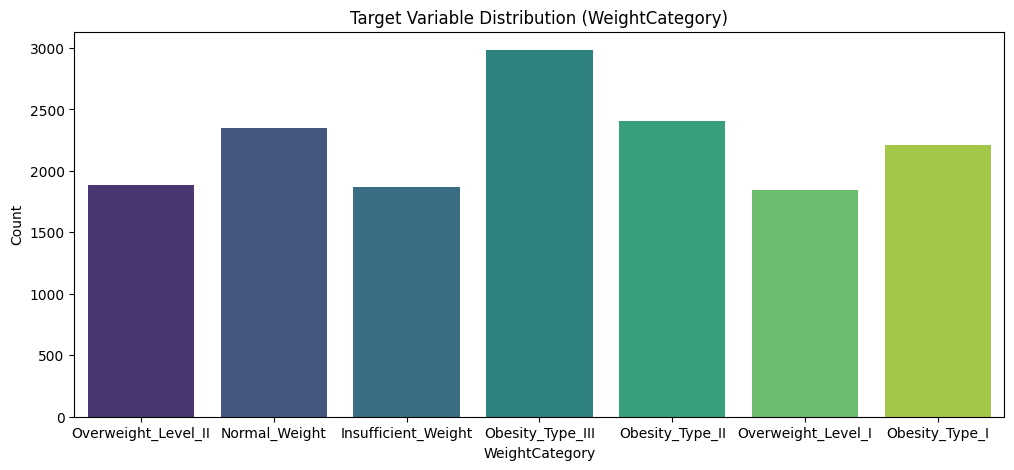


Class distribution:
WeightCategory
Obesity_Type_III       0.192
Obesity_Type_II        0.155
Normal_Weight          0.151
Obesity_Type_I         0.142
Overweight_Level_II    0.121
Insufficient_Weight    0.120
Overweight_Level_I     0.119
Name: proportion, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
sns.countplot(x='WeightCategory', data=train, palette='viridis')
plt.title("Target Variable Distribution (WeightCategory)")
plt.xlabel("WeightCategory")
plt.ylabel("Count")
plt.show()

print("\nClass distribution:")
print(train['WeightCategory'].value_counts(normalize=True).round(3))

Numerical columns: ['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,15533.000000,15533.000000,15533.000000,15533.000000,15533.000000,15533.000000,15533.000000,15533.000000,15533.000000
mean,7766.000000,23.816308,1.699918,87.785225,2.442917,2.760425,2.027626,0.976968,0.613813
std,4484.135201,5.663167,0.087670,26.369144,0.530895,0.706463,0.607733,0.836841,0.602223
min,0.000000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,3883.000000,20.000000,1.630927,66.000000,2.000000,3.000000,1.796257,0.007050,0.000000
50%,7766.000000,22.771612,1.700000,84.000000,2.342220,3.000000,2.000000,1.000000,0.566353
75%,11649.000000,26.000000,1.762921,111.600553,3.000000,3.000000,2.531456,1.582675,1.000000
max,15532.000000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


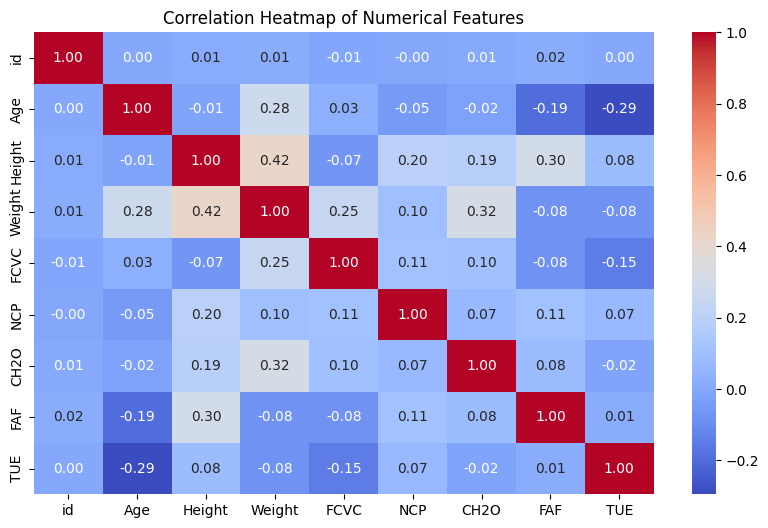

In [ ]:
# Summary statistics
num_cols=train.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical columns:", num_cols)
display(train[num_cols].describe())

# Correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(train[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

In [ ]:
# OUtlier
from scipy import stats

z_scores = np.abs(stats.zscore(train[num_cols].select_dtypes(include=[np.number]), nan_policy='omit'))
outliers = (z_scores > 3).sum(axis=0)
print("\nOutlier count (|z|>3) per column:")
print(outliers)



Outlier count (|z|>3) per column:
[  0 212   4   0   0   0   0   0   0]


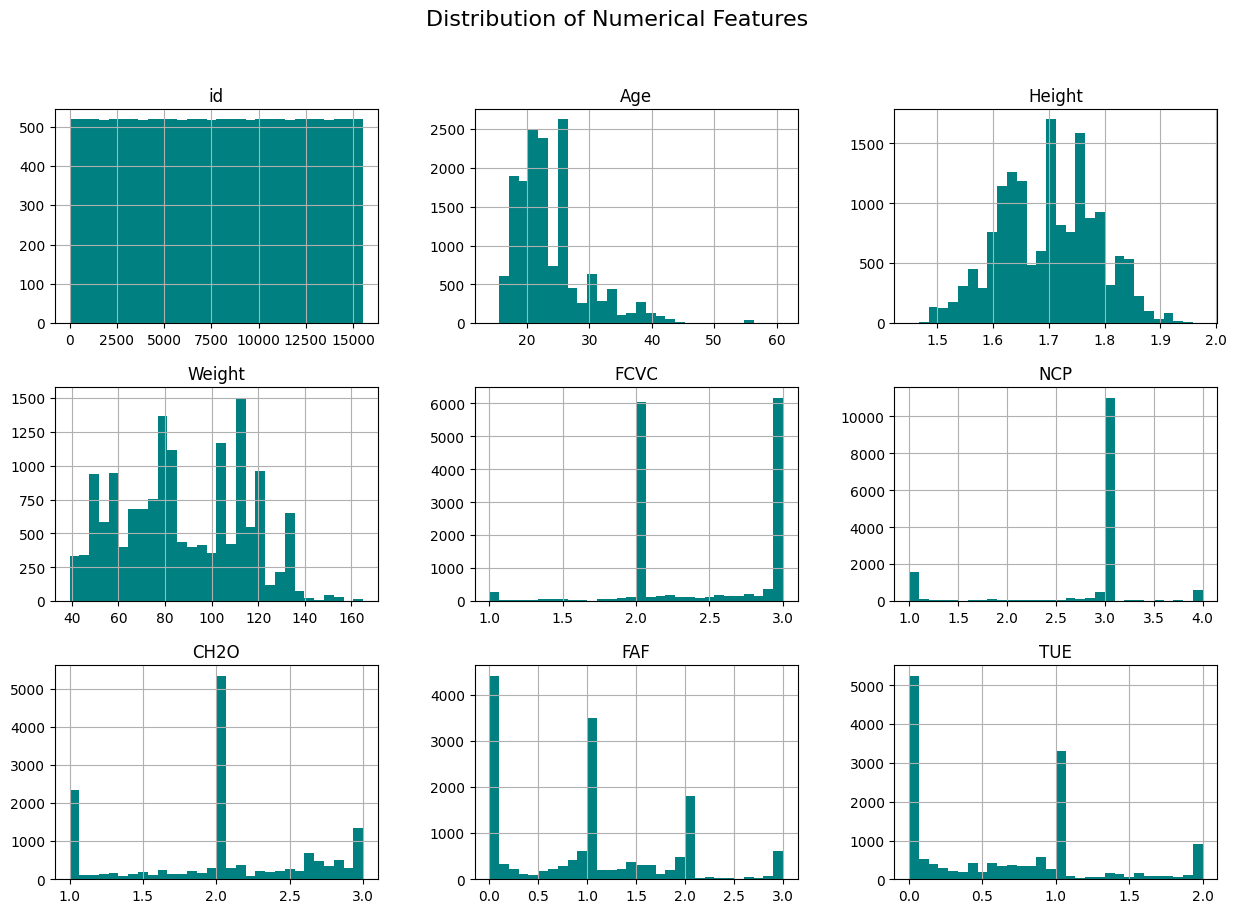

In [ ]:
# Distributions of Numerical Features
train[num_cols].hist(bins=30, figsize=(15,10), color='teal')
plt.suptitle("Distribution of Numerical Features", size=16)
plt.show()

Categorical columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'WeightCategory']


/tmp/ipython-input-546654906.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=train, order=train[col].value_counts().index, palette='muted')


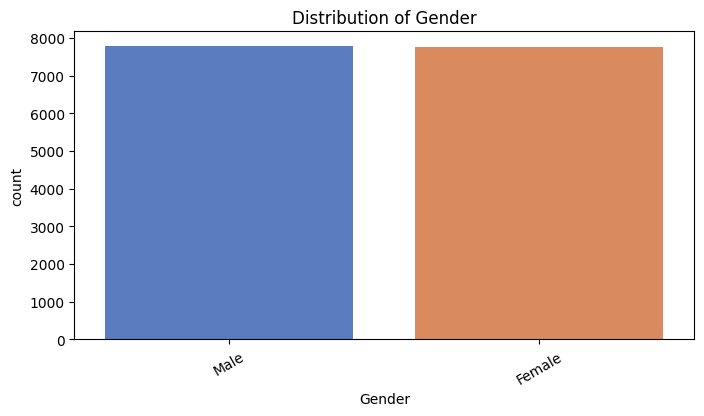

/tmp/ipython-input-546654906.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=train, order=train[col].value_counts().index, palette='muted')


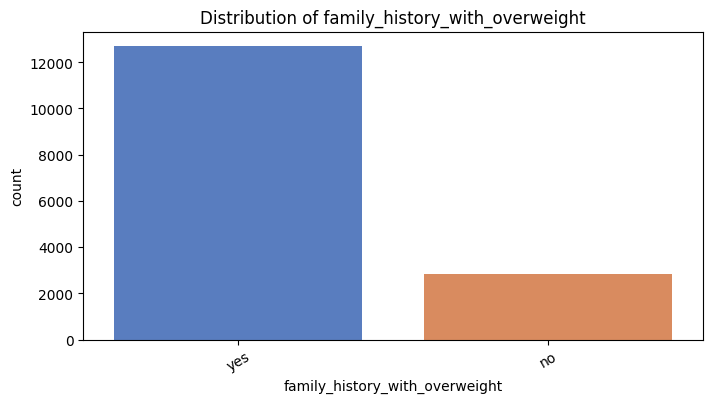

/tmp/ipython-input-546654906.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=train, order=train[col].value_counts().index, palette='muted')


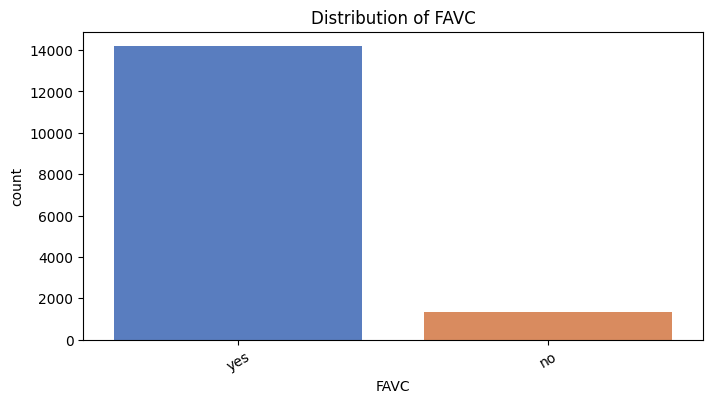

/tmp/ipython-input-546654906.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=train, order=train[col].value_counts().index, palette='muted')


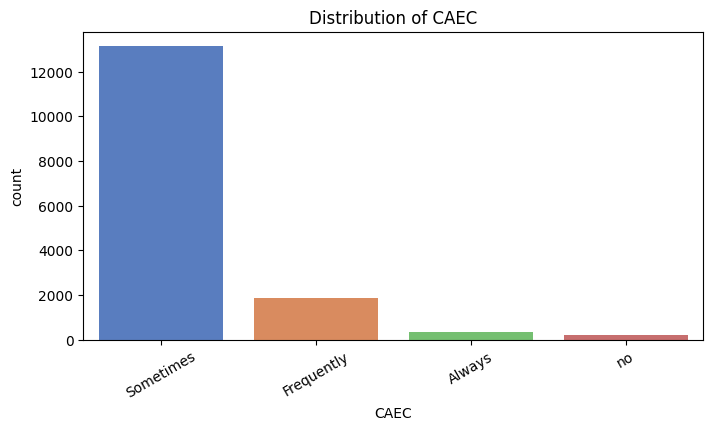

/tmp/ipython-input-546654906.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=train, order=train[col].value_counts().index, palette='muted')


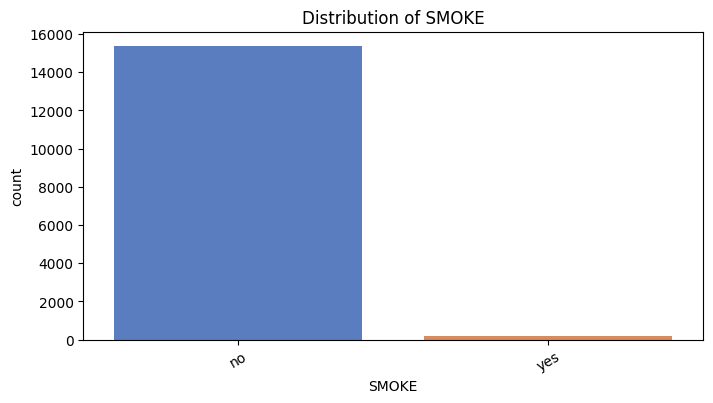

/tmp/ipython-input-546654906.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=train, order=train[col].value_counts().index, palette='muted')


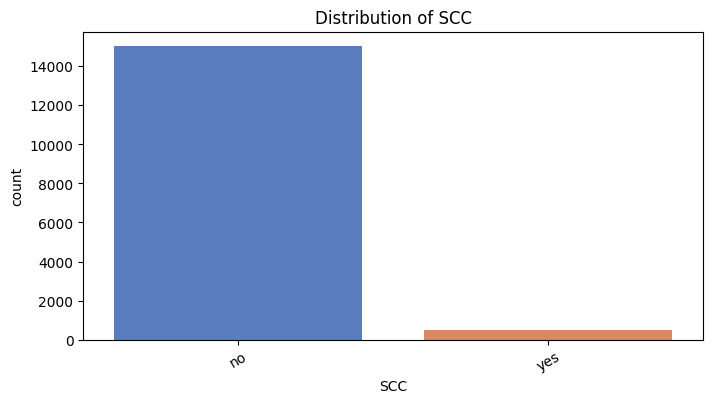

/tmp/ipython-input-546654906.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=train, order=train[col].value_counts().index, palette='muted')


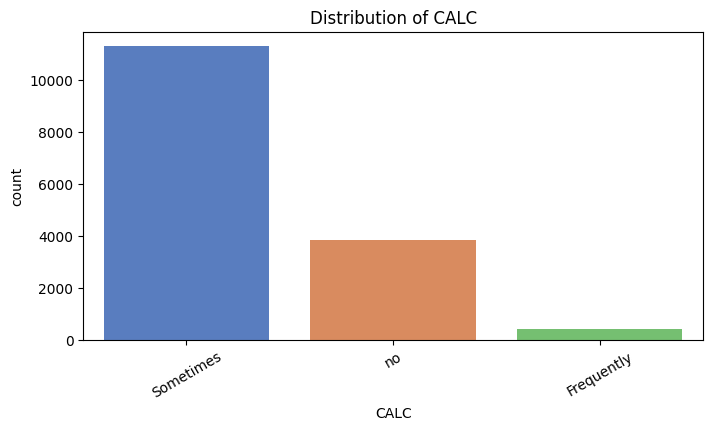

/tmp/ipython-input-546654906.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=train, order=train[col].value_counts().index, palette='muted')


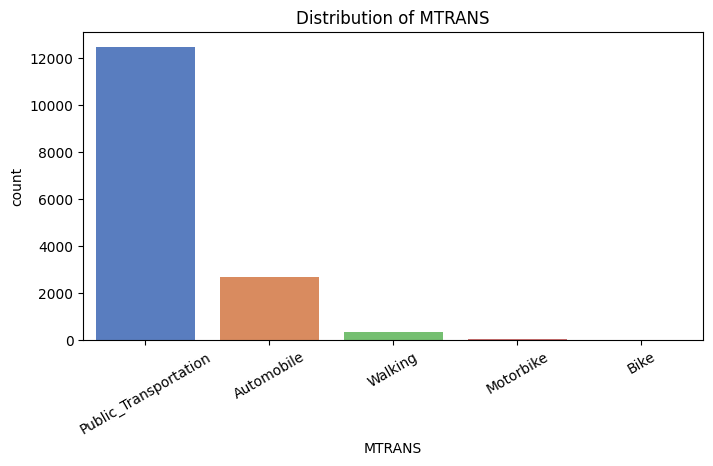

/tmp/ipython-input-546654906.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=train, order=train[col].value_counts().index, palette='muted')


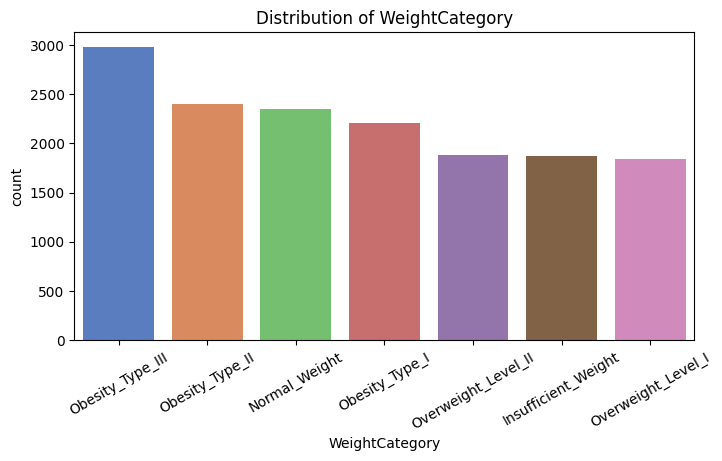

In [ ]:
# Categorical Feature Analysis
cat_cols = train.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", cat_cols)

for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, data=train, order=train[col].value_counts().index, palette='muted')
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=30)
    plt.show()

/tmp/ipython-input-3691157737.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WeightCategory', y=col, data=train, palette='cool')


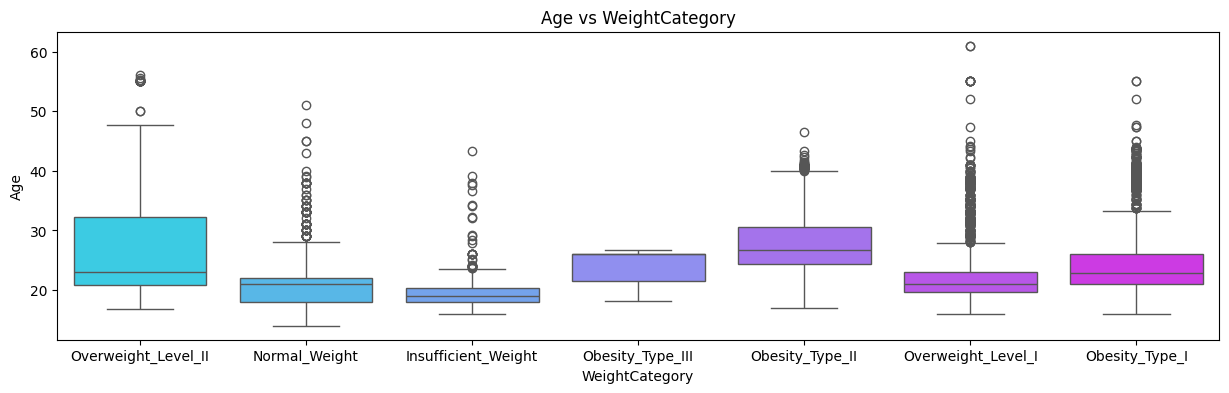

/tmp/ipython-input-3691157737.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WeightCategory', y=col, data=train, palette='cool')


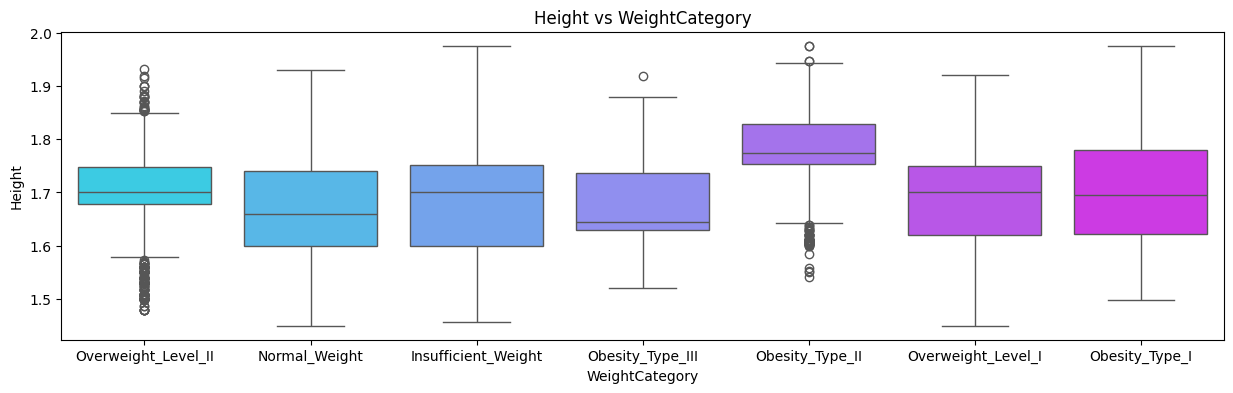

/tmp/ipython-input-3691157737.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WeightCategory', y=col, data=train, palette='cool')


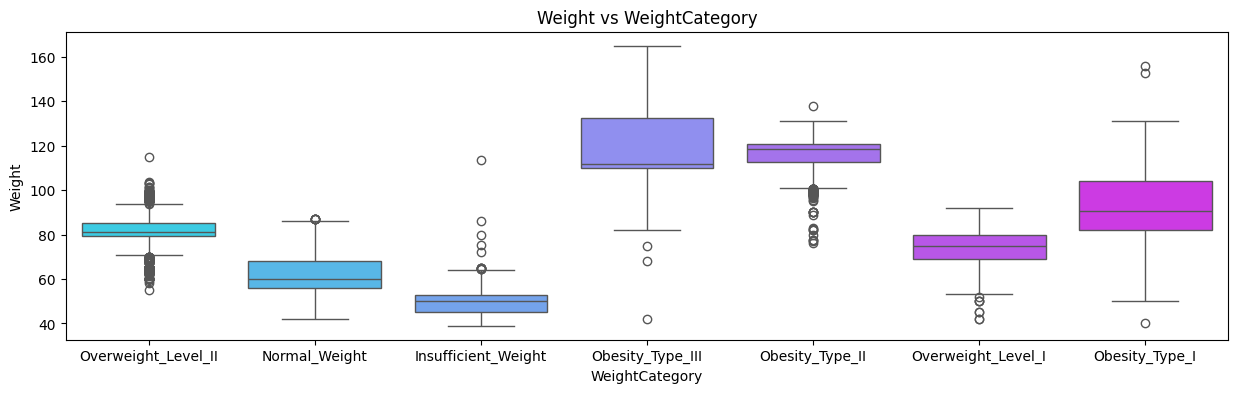

/tmp/ipython-input-3691157737.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WeightCategory', y=col, data=train, palette='cool')


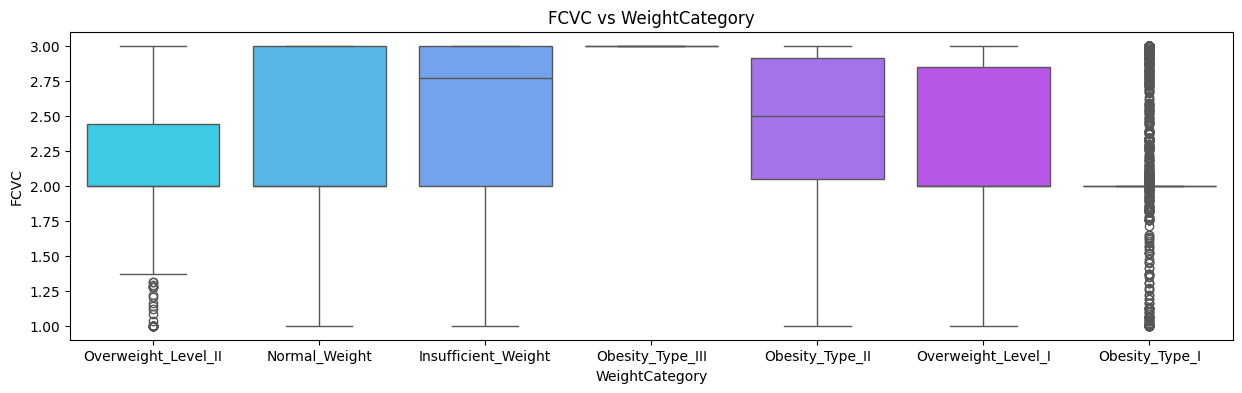

/tmp/ipython-input-3691157737.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WeightCategory', y=col, data=train, palette='cool')


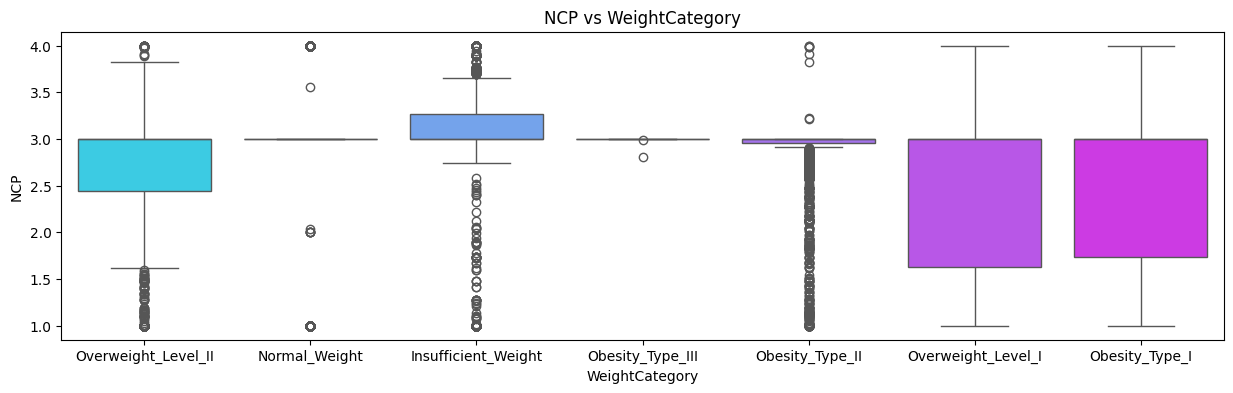

/tmp/ipython-input-3691157737.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WeightCategory', y=col, data=train, palette='cool')


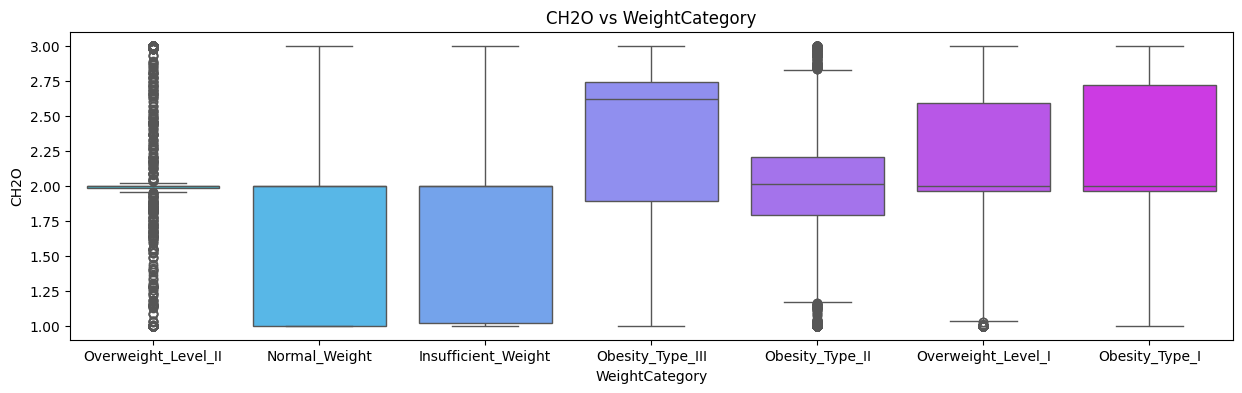

/tmp/ipython-input-3691157737.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WeightCategory', y=col, data=train, palette='cool')


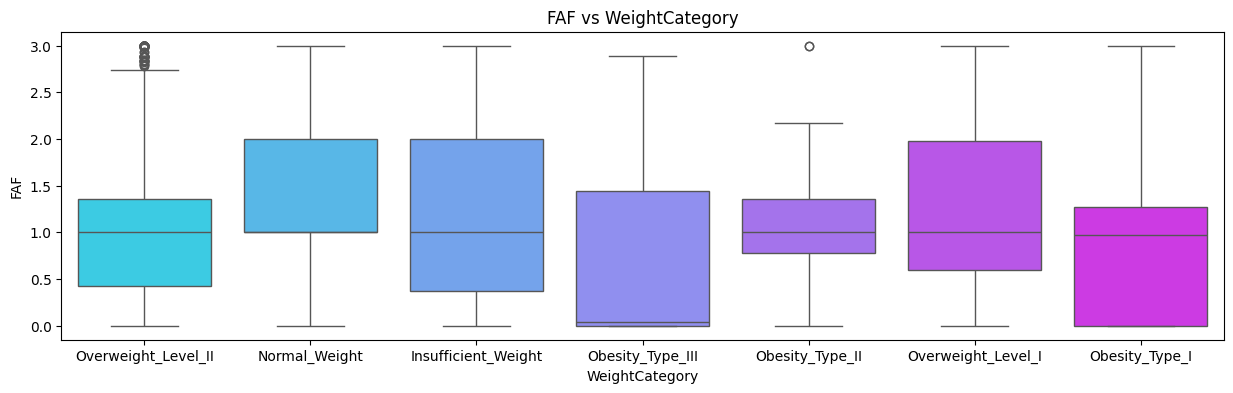

/tmp/ipython-input-3691157737.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WeightCategory', y=col, data=train, palette='cool')


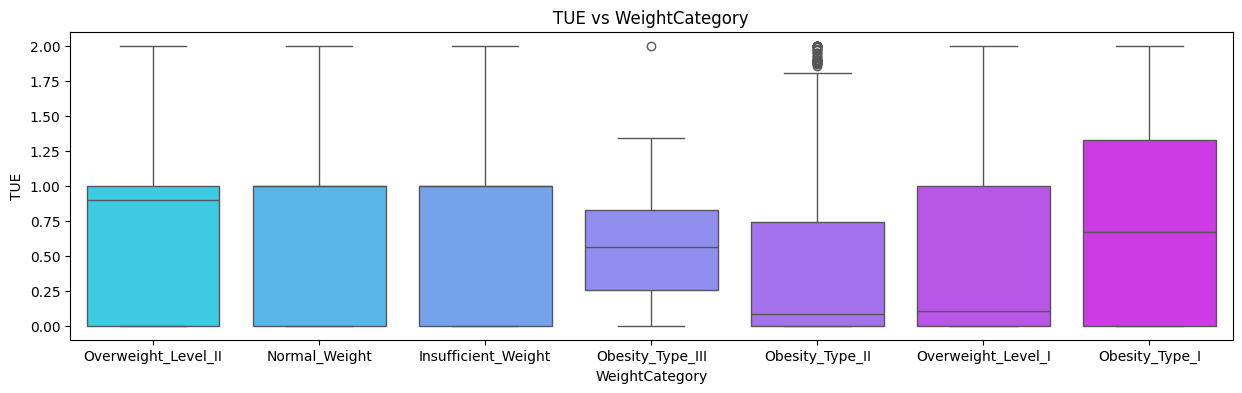

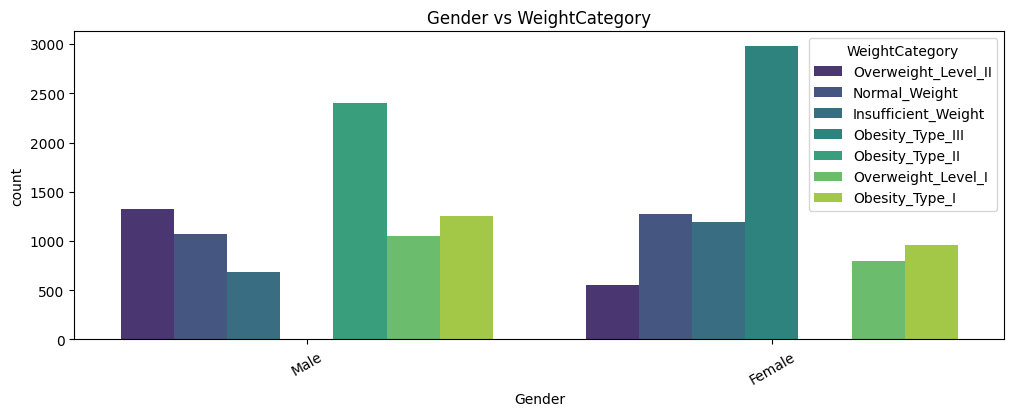

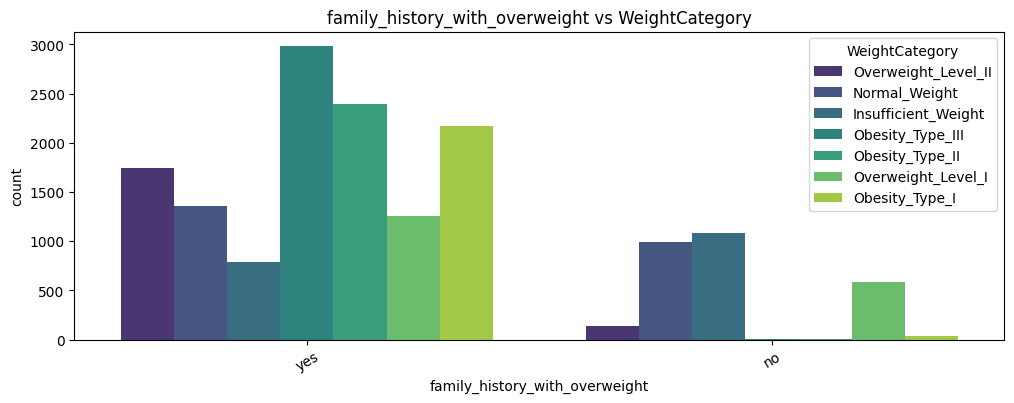

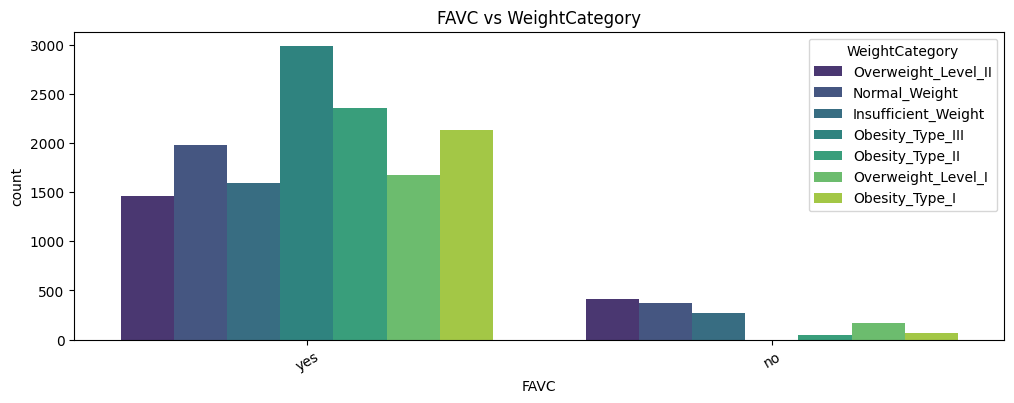

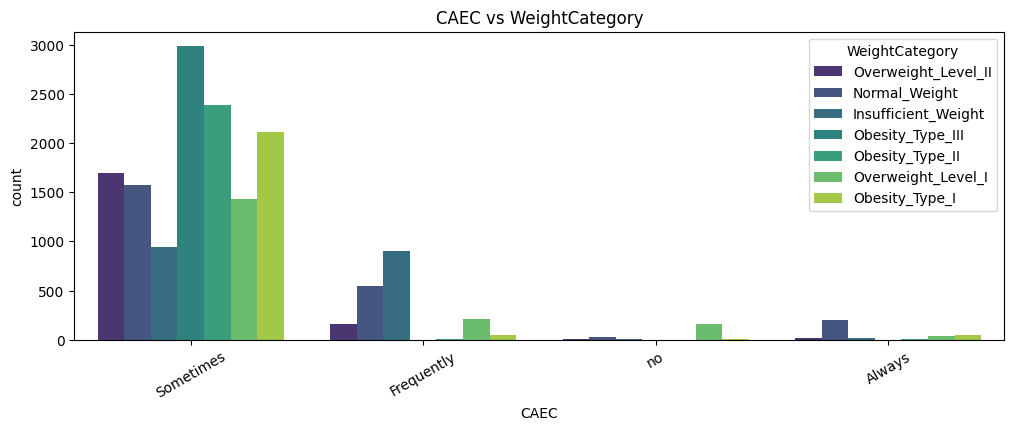

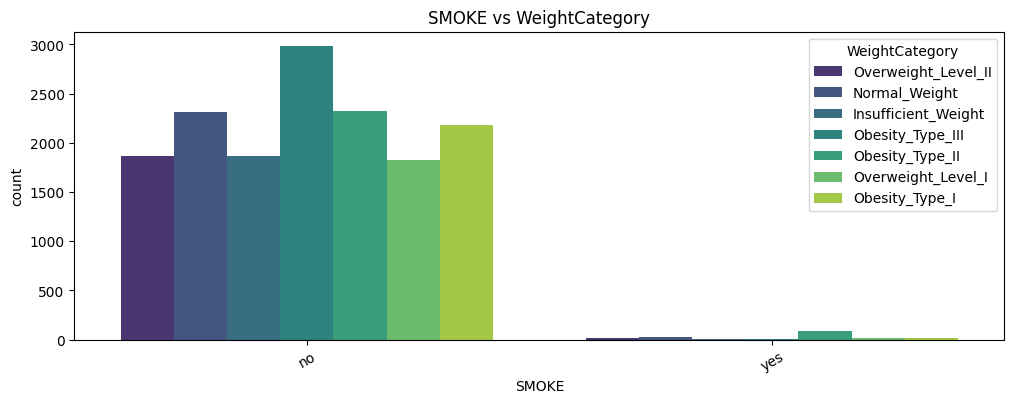

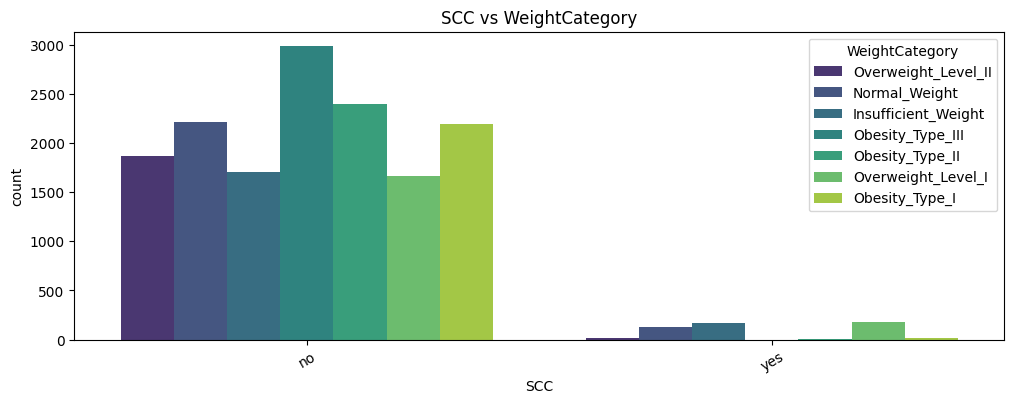

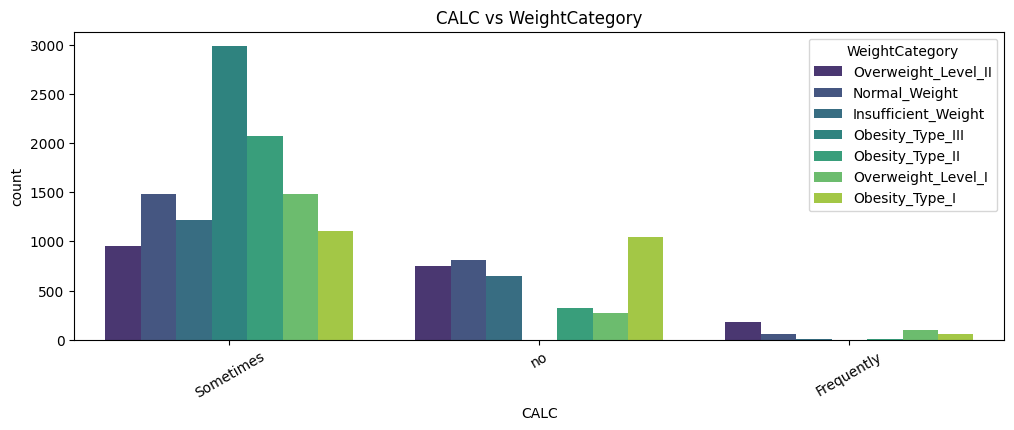

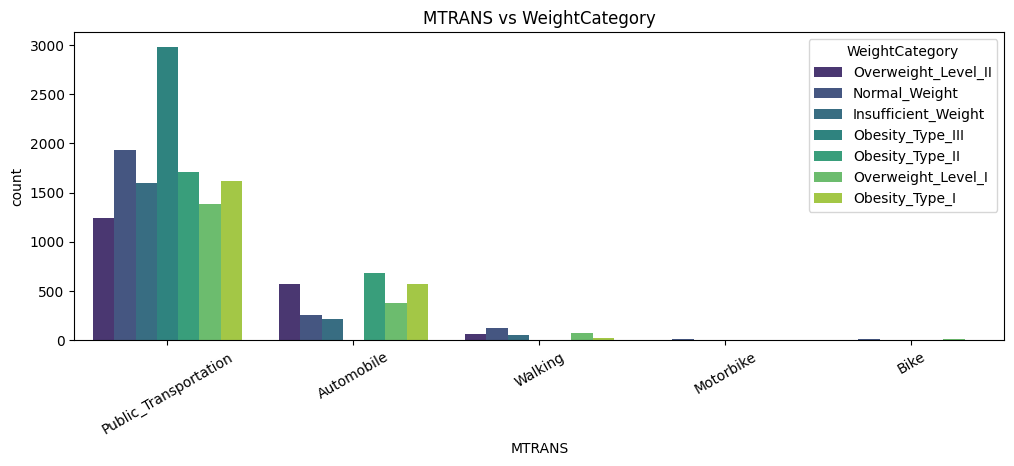

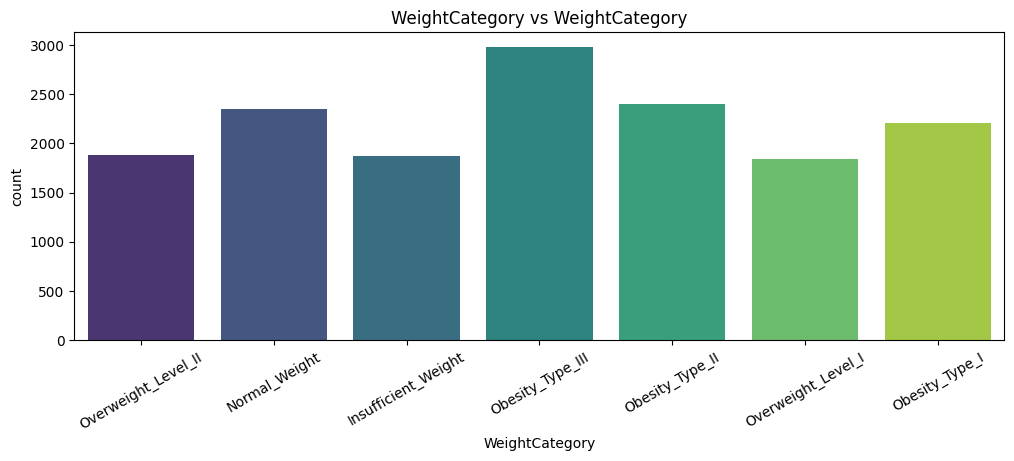

In [ ]:
# Relationship between features and target
for col in num_cols:
    if col!='id':
        plt.figure(figsize=(15,4))
        sns.boxplot(x='WeightCategory', y=col, data=train, palette='cool')
        plt.title(f"{col} vs WeightCategory")
        plt.show()

for col in cat_cols:
    plt.figure(figsize=(12,4))
    sns.countplot(x=col, hue='WeightCategory', data=train, palette='viridis')
    plt.title(f"{col} vs WeightCategory")
    plt.xticks(rotation=30)
    plt.show()

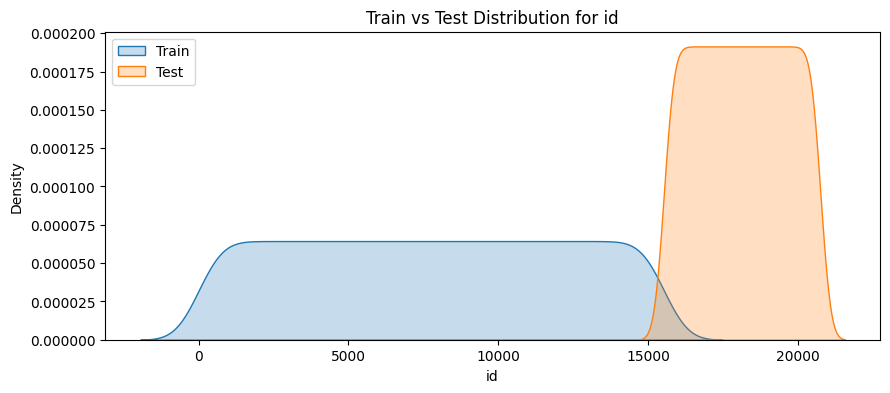

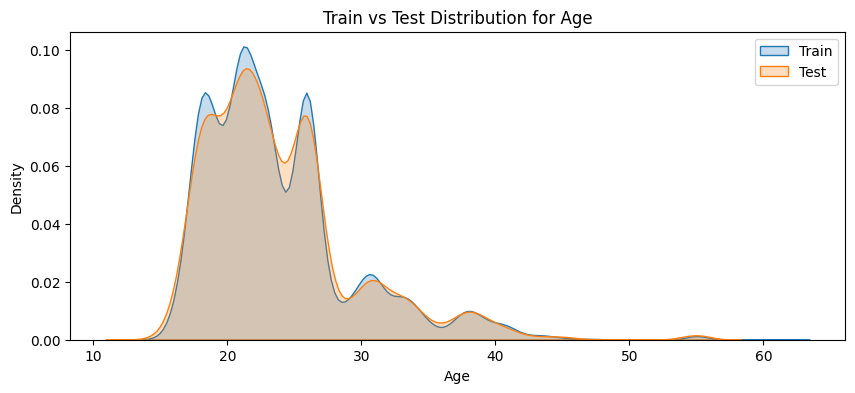

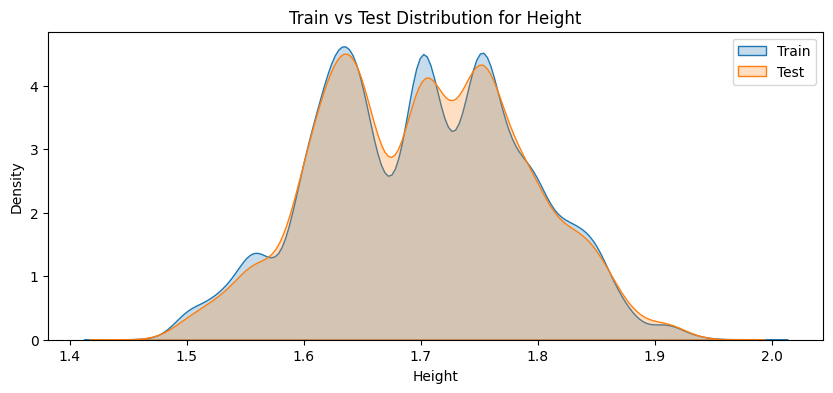

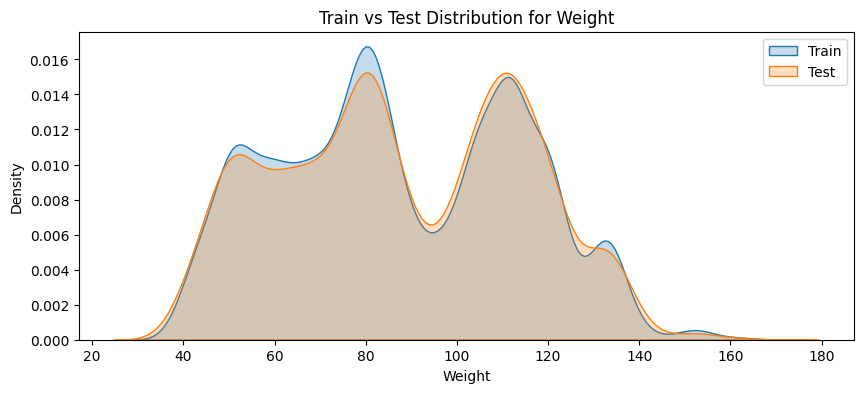

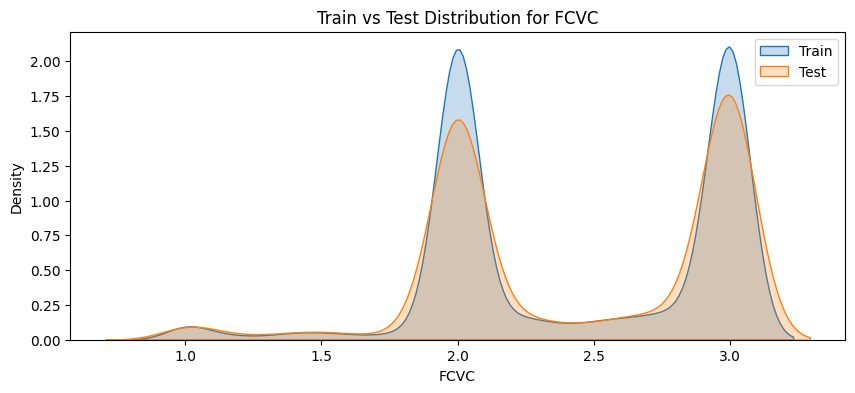

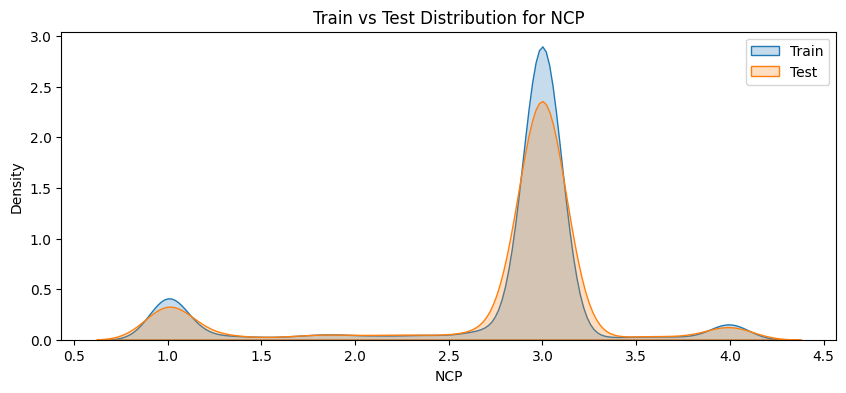

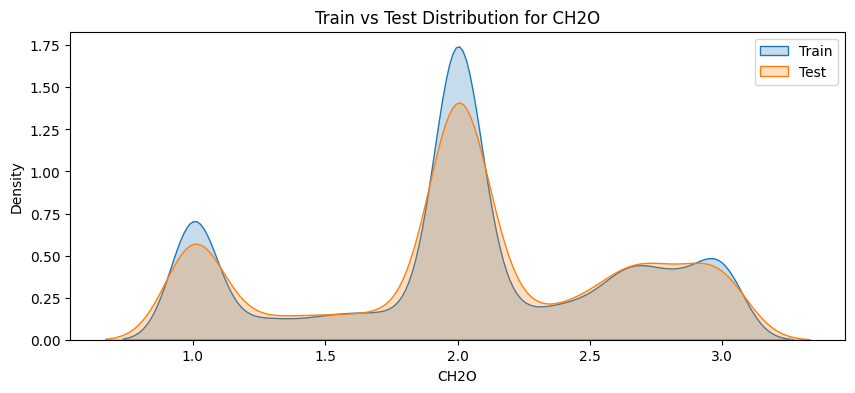

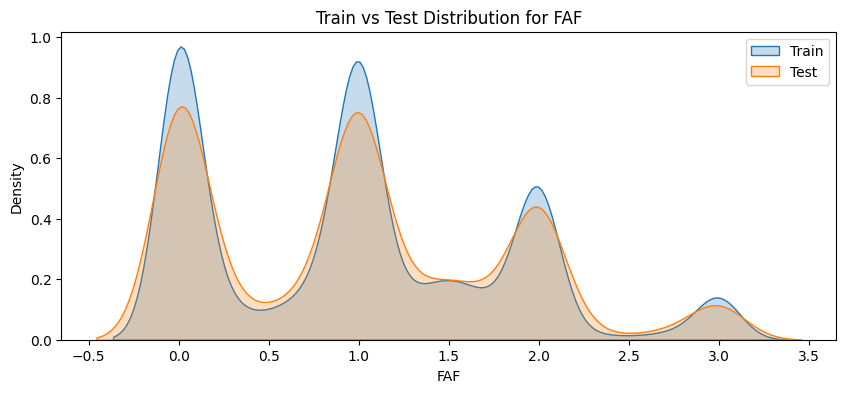

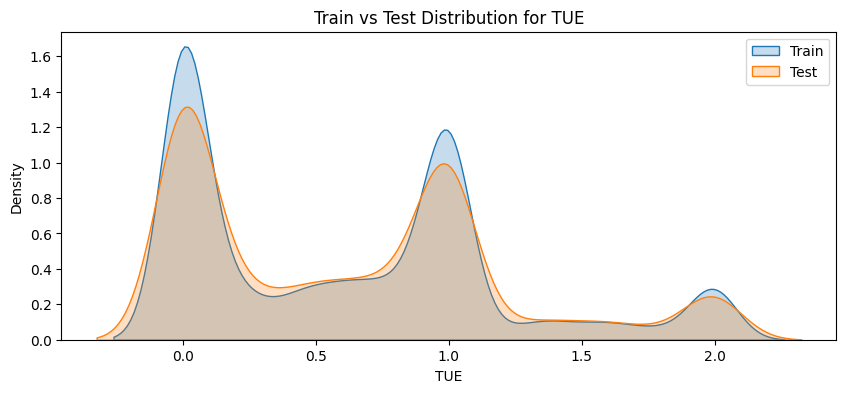

In [ ]:
# Compare Train vs Test Distributions
for col in num_cols:
    plt.figure(figsize=(10,4))
    sns.kdeplot(train[col], label='Train', fill=True)
    sns.kdeplot(test[col], label='Test', fill=True)
    plt.title(f"Train vs Test Distribution for {col}")
    plt.legend()
    plt.show()